Loaded stack shape: (1023, 512, 512) dtype: uint16
✅ Final processed TIFF saved to: /Volumes/Expansion/Pleomorphisms/20230717_CsSpotAssayLiqMed/Jan 2026/C3-MB_005_blue_processed.tif
🎬 Annotated movie saved to: /Volumes/Expansion/Pleomorphisms/20230717_CsSpotAssayLiqMed/Jan 2026/C3-MB_005_blue_processed_annotated.mp4


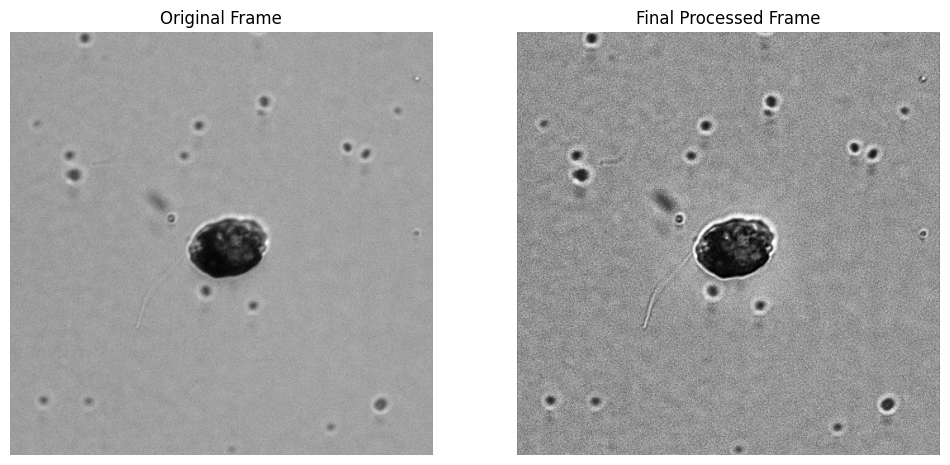

In [4]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tifffile
from scipy.ndimage import gaussian_filter
from PIL import ImageFont, ImageDraw, Image

# -- FILE PATHS --
input_file = "/Volumes/Expansion/Pleomorphisms/20230717_CsSpotAssayLiqMed/Jan 2026/C3-MB_005_1.tif"
output_tif = "/Volumes/Expansion/Pleomorphisms/20230717_CsSpotAssayLiqMed/Jan 2026/C3-MB_005_blue_processed.tif"
output_movie = "/Volumes/Expansion/Pleomorphisms/20230717_CsSpotAssayLiqMed/Jan 2026/C3-MB_005_blue_processed_annotated.mp4"

# -- PARAMETERS --
sigma_smooth_background = 2.0
unsharp_amount = 1.5
clahe_clip_limit = 1.5
final_blur_sigma = 0.3
temporal_window = 3

time_per_frame = 0.05868  # seconds
pixel_size = 0.1625       # microns/pixel
scale_bar_microns = 10    # scale bar size in microns
scale_bar_height = 5      # height of scale bar in pixels
font_path = "/Library/Fonts/SuisseIntlMono-Regular.ttf"  # <-- Update this if different!
font_size = 16            # size for text overlay

# -- LOAD IMAGE STACK --
stack = tifffile.imread(input_file)
print(f"Loaded stack shape: {stack.shape} dtype: {stack.dtype}")

n_frames, height, width = stack.shape

# -- PROCESS EACH FRAME --
processed_frames = []

for i in range(n_frames):
    img16 = stack[i]

    # Normalize 16-bit to 8-bit
    img = cv2.normalize(img16, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Smooth background heavily
    background = gaussian_filter(img, sigma=sigma_smooth_background)

    # Unsharp masking
    img_unsharp = cv2.addWeighted(img, 1 + unsharp_amount, background, -unsharp_amount, 0)

    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=clahe_clip_limit, tileGridSize=(8,8))
    img_clahe = clahe.apply(img_unsharp)

    processed_frames.append(img_clahe)

processed_stack = np.stack(processed_frames, axis=0)

# -- TEMPORAL SMOOTHING --
pad_width = temporal_window // 2
padded = np.pad(processed_stack, ((pad_width, pad_width), (0, 0), (0, 0)), mode='edge')
smoothed_stack = np.empty_like(processed_stack)

for i in range(n_frames):
    smoothed_stack[i] = np.mean(padded[i:i+temporal_window], axis=0)

# -- FINAL GENTLE SMOOTHING --
final_stack = np.empty_like(smoothed_stack)

for i in range(n_frames):
    final_stack[i] = gaussian_filter(smoothed_stack[i], sigma=final_blur_sigma)

# -- SAVE FINAL STACK --
tifffile.imwrite(output_tif, final_stack.astype(np.uint8))
print(f"✅ Final processed TIFF saved to: {output_tif}")

# -- SETUP FONT --
try:
    font = ImageFont.truetype(font_path, font_size)
except:
    print("⚠️ Suisse Intl Mono not found! Using default system monospace font.")
    font = ImageFont.truetype("/System/Library/Fonts/SFNSMono.ttf", font_size)  # Menlo/Monaco alternative

# -- MAKE MOVIE WITH ANNOTATIONS --
fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = int(1 / time_per_frame)
out = cv2.VideoWriter(output_movie, fourcc, fps, (2*width, height), isColor=False)

scale_bar_length_pixels = int(scale_bar_microns / pixel_size)

for i in range(n_frames):
    original_frame = stack[i]
    original_norm = cv2.normalize(original_frame, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    processed_frame = final_stack[i].astype(np.uint8)

    # Stack side-by-side
    combined = np.hstack((original_norm, processed_frame))

    # Convert to PIL Image for text overlay
    pil_img = Image.fromarray(combined)
    draw = ImageDraw.Draw(pil_img)

    # Draw timestamp
    timestamp_text = f"Time: {i * time_per_frame:.2f} s"
    draw.text((10, 10), timestamp_text, font=font, fill=255)

    # Draw scale bar (bottom right corner)
    scale_bar_start_x = combined.shape[1] - scale_bar_length_pixels - 20
    scale_bar_start_y = combined.shape[0] - 30
    draw.rectangle([scale_bar_start_x, scale_bar_start_y, scale_bar_start_x + scale_bar_length_pixels, scale_bar_start_y + scale_bar_height], fill=255)

    # Draw scale bar label
    draw.text((scale_bar_start_x, scale_bar_start_y - 20), f"{scale_bar_microns} µm", font=font, fill=255)

    # Convert back to OpenCV format
    frame_with_text = np.array(pil_img)

    out.write(frame_with_text)

out.release()

print(f"🎬 Annotated movie saved to: {output_movie}")

# -- SHOW SAMPLE FRAME --
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(stack[n_frames//2], cmap='gray')
plt.title('Original Frame')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(final_stack[n_frames//2], cmap='gray')
plt.title('Final Processed Frame')
plt.axis('off')
plt.show()